## Prepare the dataset
- Unzip the dataset
- Install dependencies for the AWS kernel

In [3]:
!unzip 'Plastic_Bottle_Image_Dataset.zip'

Archive:  Plastic_Bottle_Image_Dataset.zip
   creating: Plastic_Bottle_Image_Dataset/
  inflating: Plastic_Bottle_Image_Dataset/data-v8.yaml  
  inflating: Plastic_Bottle_Image_Dataset/data.yaml  
   creating: Plastic_Bottle_Image_Dataset/test/
   creating: Plastic_Bottle_Image_Dataset/test/images/
  inflating: Plastic_Bottle_Image_Dataset/test/images/-136_jpg.rf.b58c092e504d1e1f0bb5d5cbf60ad415.jpg  
  inflating: Plastic_Bottle_Image_Dataset/test/images/-171_jpg.rf.513b40a00a8128949d034c41662c0c59.jpg  
  inflating: Plastic_Bottle_Image_Dataset/test/images/-18_jpg.rf.9e168f61ceff6dcd69f8e65369745459.jpg  
  inflating: Plastic_Bottle_Image_Dataset/test/images/-216_jpg.rf.41406aa65c99402c41e2d3d03f670476.jpg  
  inflating: Plastic_Bottle_Image_Dataset/test/images/-253_jpg.rf.8ee591edcfd2f79c5b88f85d886925ac.jpg  
  inflating: Plastic_Bottle_Image_Dataset/test/images/-270_jpg.rf.53131f2b9a95d9f9a0f3bc5b35e29a4b.jpg  
  inflating: Plastic_Bottle_Image_Dataset/test/images/-285_jpg.rf.88955

In [3]:
# clone the main repository folder and use it for the install directory
!git clone https://github.com/ultralytics/yolov5

%cd yolov5
from yolov5 import utils

!pip install opencv-python
!pip install torch
!pip install torchvision 

!pip install -r requirements.txt

!apt-get update && apt-get install ffmpeg libsm6 libxext6  -y

display = utils.notebook_init()  # checks Pytorch and GPU used
%cd ../

YOLOv5 🚀 v7.0-172-gc3c1304 Python-3.7.10 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (4 CPUs, 15.4 GB RAM, 3.6/32.0 GB disk)
/root


## Create a train_yaml file
- Write a default yolov5 configuration for training
- Include the yolov5 backbone, head, and anchor parameters

In [7]:
%cd 'Plastic_Bottle_Image_Dataset'

with open('train_yaml', 'w+') as file:
    file.write(
        f"""
        # parameters
        nc: 1  # number of classes
        depth_multiple: 0.33  # model depth multiple
        width_multiple: 0.50  # layer channel multiple

        # anchors
        anchors:
          - [10,13, 16,30, 33,23]  # P3/8
          - [30,61, 62,45, 59,119]  # P4/16
          - [116,90, 156,198, 373,326]  # P5/32

        # YOLOv5 backbone
        backbone:
          # [from, number, module, args]
          [[-1, 1, Focus, [64, 3]],  # 0-P1/2
           [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
           [-1, 3, BottleneckCSP, [128]],
           [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
           [-1, 9, BottleneckCSP, [256]],
           [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
           [-1, 9, BottleneckCSP, [512]],
           [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
           [-1, 1, SPP, [1024, [5, 9, 13]]],
           [-1, 3, BottleneckCSP, [1024, False]],  # 9
          ]

        # YOLOv5 head
        head:
          [[-1, 1, Conv, [512, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 6], 1, Concat, [1]],  # cat backbone P4
           [-1, 3, BottleneckCSP, [512, False]],  # 13

           [-1, 1, Conv, [256, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 4], 1, Concat, [1]],  # cat backbone P3
           [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

           [-1, 1, Conv, [256, 3, 2]],
           [[-1, 14], 1, Concat, [1]],  # cat head P4
           [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

           [-1, 1, Conv, [512, 3, 2]],
           [[-1, 10], 1, Concat, [1]],  # cat head P5
           [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

           [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
          ]
        """
    )

%cd '../'

/root/Plastic_Bottle_Image_Dataset
/root


## Train the model
- First command trains the model used for final selection
- Second command has been used to resume model training and is commented by default

In [ ]:
!python yolov5/train.py --img 640 --batch 8 --epochs 300 --save-period 5 --data /root/Plastic_Bottle_Image_Dataset/data.yaml  --cfg /root/Plastic_Bottle_Image_Dataset/train_yaml --weights /root/yolov5/runs/train/exp/weights/best.pt
# !python yolov5/train.py  --weights /root/yolov5/runs/train/exp/weights/last.pt --resume


train: weights=/root/yolov5/runs/train/exp/weights/best.pt, cfg=/root/Plastic_Bottle_Image_Dataset/train_yaml, data=/root/Plastic_Bottle_Image_Dataset/data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=300, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=5, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
requirements: Ultralytics requirement "PyYAML>=5.3.1" not found, attempting AutoUpdate...

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

requirements: 1 packa

## Display Result Metrics
- Print generated result metrics from yolov5
- assumes a default /exp/ folder

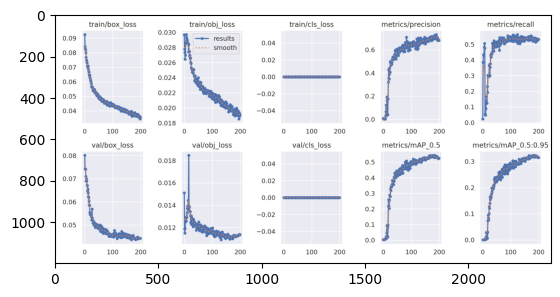

In [4]:
import cv2
from matplotlib import pyplot as plt
from PIL import Image

# This is needed to display the images.
%matplotlib inline
image = Image.open('yolov5/runs/train/exp/results.png')
plt.imshow(image)


## Perform model validation

- Run the validation script on the provided validation set and best model

In [7]:
!python yolov5/val.py --data /root/Plastic_Bottle_Image_Dataset/data.yaml --weights /root/yolov5/runs/train/exp/weights/best.pt

val: data=/root/Plastic_Bottle_Image_Dataset/data.yaml, weights=['/root/yolov5/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
requirements: Ultralytics requirement "PyYAML>=5.3.1" not found, attempting AutoUpdate...

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

requirements: 1 package updated per /root/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v7.0-172-gc3c1304 Python-3.7.10 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
train_yaml summary: 182 layers, 7246518 parameters, 0 gradients
val: Scanning /root/Plastic_Bottle_Image_Dataset/valid/labels.cache... 574 i

## Print results generated
- Function to print the:
    - confusion matrix
    - F1 Curve
    - Validation labels vs predictions

<Figure size 640x480 with 0 Axes>

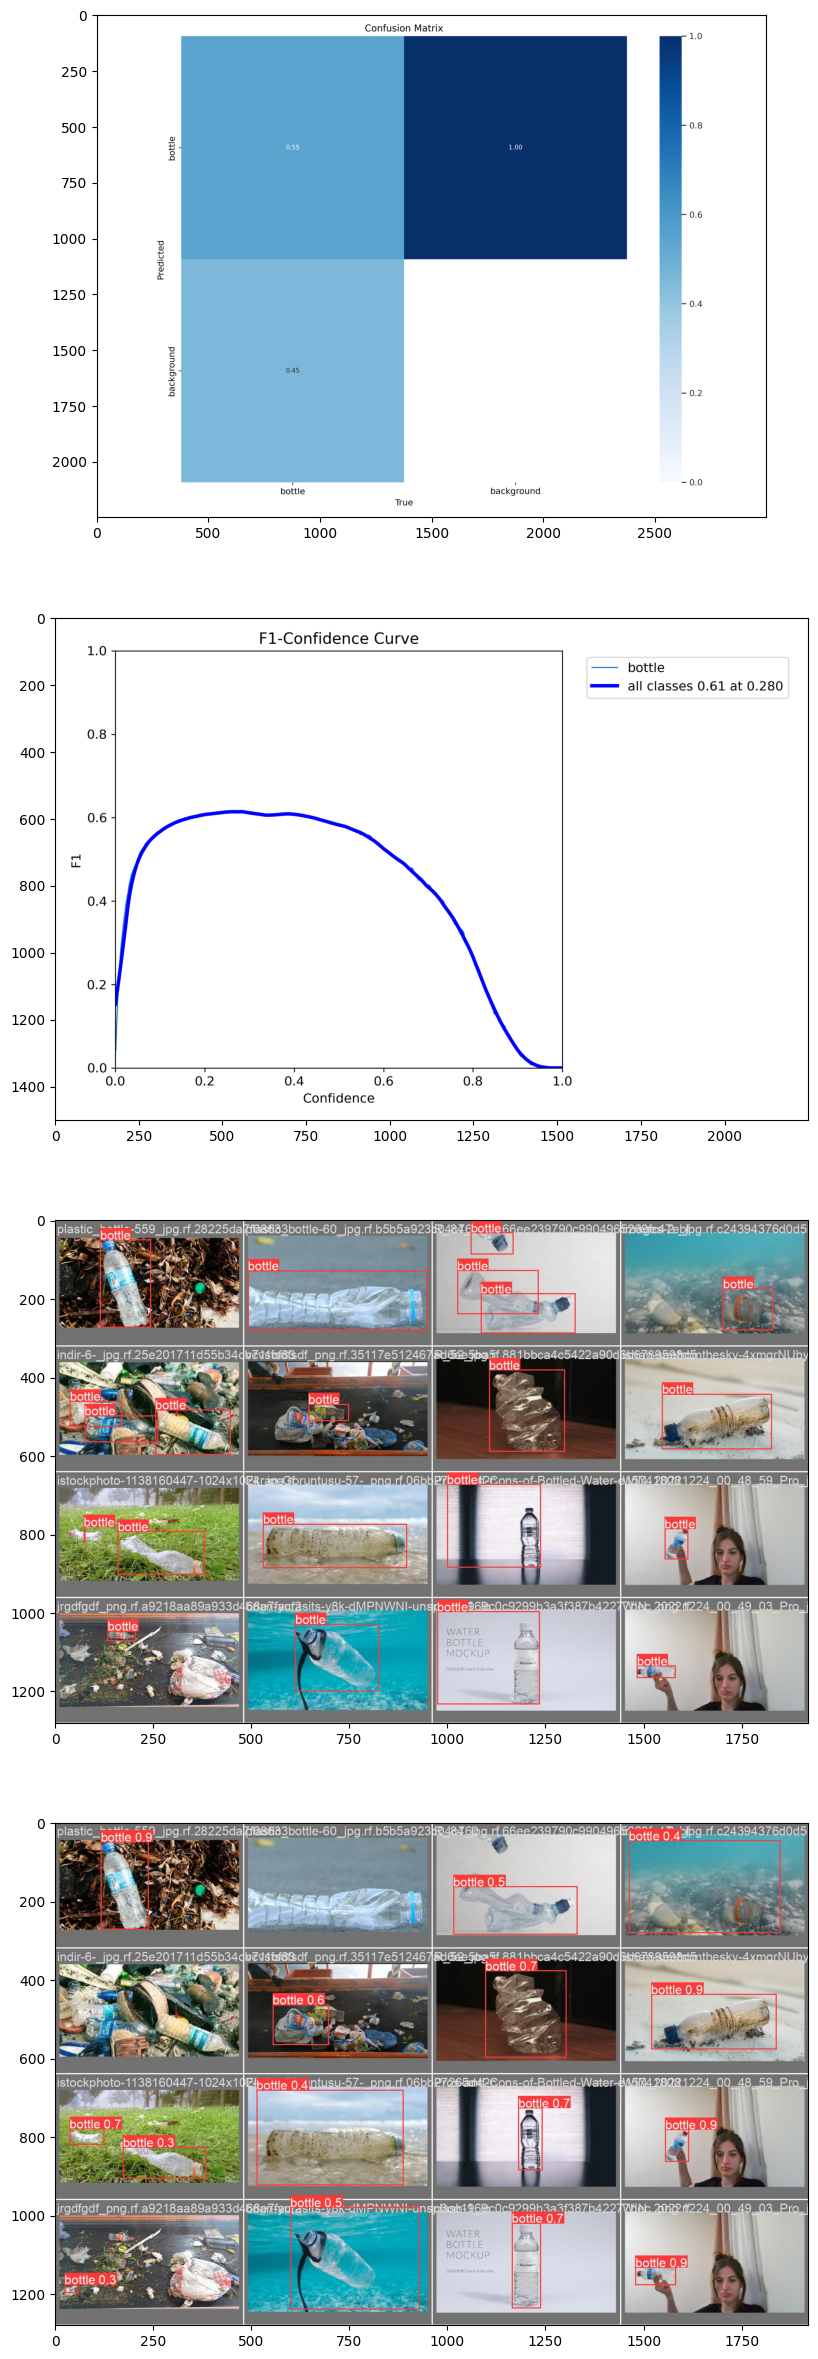

In [8]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(4,1, figsize = (30,30)) 

# 4 images stacked vertically using the array subplots
image = Image.open('/root/yolov5/runs/val/exp/confusion_matrix.png')
axarr[0].imshow(image)

image = Image.open('/root/yolov5/runs/val/exp/F1_curve.png')
axarr[1].imshow(image)

image = Image.open('/root/yolov5/runs/val/exp/val_batch0_labels.jpg')
axarr[2].imshow(image)

image = Image.open('/root/yolov5/runs/val/exp/val_batch0_pred.jpg')
axarr[3].imshow(image)


## Test the model
- Run the validation script on the test dataset to obtain its test precision

In [9]:
!python yolov5/val.py --data /root/Plastic_Bottle_Image_Dataset/data.yaml --weights /root/yolov5/runs/train/exp/weights/best.pt --task test

val: data=/root/Plastic_Bottle_Image_Dataset/data.yaml, weights=['/root/yolov5/runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
requirements: Ultralytics requirement "PyYAML>=5.3.1" not found, attempting AutoUpdate...

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip

requirements: 1 package updated per /root/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v7.0-172-gc3c1304 Python-3.7.10 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
train_yaml summary: 182 layers, 7246518 parameters, 0 gradients
test: Scanning /root/Plastic_Bottle_Image_Dataset/test/labels... 648 images

## Export the model
- Export the model to tflite format for deployment with an android platform

In [11]:
!python yolov5/export.py --weights /root/yolov5/runs/train/exp/weights/best.pt --include tflite --img 640

export: data=yolov5/data/coco128.yaml, weights=['/root/yolov5/runs/train/exp/weights/best.pt'], imgsz=[640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['tflite']
YOLOv5 🚀 v7.0-172-gc3c1304 Python-3.7.10 torch-1.13.1+cu117 CPU

Fusing layers... 
train_yaml summary: 182 layers, 7246518 parameters, 0 gradients

PyTorch: starting from /root/yolov5/runs/train/exp/weights/best.pt with output shape (1, 25200, 6) (14.1 MB)
requirements: Ultralytics requirement "tensorflow-cpu" not found, attempting AutoUpdate...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker 2.145.0 requires importlib-metadata<5.0,>=1.4.0, but you have importlib-metada